In [27]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sklearn.metrics import (
    balanced_accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from scipy.stats import multivariate_normal, entropy
from scipy.integrate import nquad

def _autoregressive_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    # cov_matrix = rho ** np.abs(i - j)
    cov_matrix = 1/(rho ** np.abs(i - j))
    return cov_matrix

def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix

In [3]:
def Calculate_SA98(y_true, y_pred_proba, max_fpr=0.02) -> float:
    if y_true.squeeze().ndim != 1:
        raise ValueError(f"y_true must be 1d, not {y_true.shape}")
    if 0 in y_true or -1 in y_true:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=1, drop_intermediate=False
        )
    else:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=2, drop_intermediate=False
        )
    s98 = max([tpr for (fpr, tpr) in zip(fpr, tpr) if fpr <= max_fpr])
    return s98


def Calculate_MI(y_true, y_pred_proba):
    H_YX = np.mean(entropy(y_pred_proba, base=np.exp(1), axis=1))
    # empirical count of each class (n_classes)
    _, counts = np.unique(y_true, return_counts=True)
    H_Y = entropy(counts, base=np.exp(1))
    return H_Y - H_YX

In [30]:



def make_trunk_classification(
    n_samples,
    n_dim=10,
    n_informative=1,
    mu_1=1.0,
    mu_0=0.0,
    m_factor: int = -1,
    cov_par: int = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: int = 0.9,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)

    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = cov_par * np.identity(n_informative)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if mix == 0:
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    else:
        mixture_idx = rng.choice(
            [0, 1], n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        X_mixture = np.zeros((n_samples // 2, len(mu_1)))
        for idx in range(n_samples // 2):
            if mixture_idx[idx] == 1:
                X_sample = rng.multivariate_normal(mu_1, cov, 1, method=method)
            else:
                X_sample = rng.multivariate_normal(mu_0, cov, 1, method=method)
            X_mixture[idx, :] = X_sample

        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture,
            )
        )

    if n_dim > n_informative:
        # X = np.hstack((X, rng.uniform(low=0, high=1, size=(n_samples, n_dim - n_informative))))
        X = np.hstack(
            (
                X,
                rng.multivariate_normal(
                    np.zeros(n_dim - n_informative),
                    cov_par * np.identity(n_dim - n_informative),
                    n_samples,
                    method=method,
                ),
            )
        )

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        return X, y, [mu_0, mu_1], [cov, cov]
    return X, y

In [28]:
# define the script below as a function
observe_probas = []
null_probas = []
def _run_experiment(
    i,
    j,
    n_dim,
    mu_1,
    mu_0,
    mix,
):
    X, y = make_trunk_classification(
        n_samples=j,
        n_dim=n_dim,
        mu_1=mu_1,
        mu_0=mu_0,
        mix=mix,
        seed=i,
    )
    # define the model
    est = HonestForestClassifier(
        n_estimators=2000,
        max_samples=1.6,
        max_features=0.3,
        bootstrap=True,
        stratify=True,
        n_jobs=-2,
        random_state=i,
    )
    observe_probas.append([])
    null_probas.append([])
    _, observe_proba = build_hyppo_oob_forest(est, X, y)
    observe_probas[i].append(observe_proba)
    with open(f"./outputs/mix_observe_pos_{i}_{j}.pkl", "wb") as f:
        pickle.dump(observe_probas, f)

    np.random.shuffle(y)
    _, null_proba = build_hyppo_oob_forest(est, X, y)
    null_probas[i].append(null_proba)
    with open(f"./outputs/mix_null_pos.pkl_{i}_{j}", "wb") as f:
        pickle.dump(null_probas, f)
    return observe_proba, null_proba

In [31]:
SAMPLE_SIZES = [256, 512, 1024, 2048, 4096]
DIM_SIZES = [2**i for i in range(2, 13)]
FIXED_SIZE = 1
N_ITR = 10
dim = FIXED_SIZE

observe_probas = []
null_probas = []
for i in range(N_ITR):
    # print(i)
    observe_probas.append([])
    null_probas.append([])
    for j in SAMPLE_SIZES:
        # print(j)
        X, y = make_trunk_classification(
            n_samples=j, n_dim=dim, n_informative=1, seed=i, mu_1=1.0, mix=0.5
        )

        est = HonestForestClassifier(
            n_estimators=2000,
            max_samples=1.6,
            max_features=0.3,
            bootstrap=True,
            stratify=True,
            n_jobs=48,
            random_state=i,
        )
        _, observe_proba = build_hyppo_oob_forest(est, X, y)
        observe_probas[i].append(observe_proba)

        np.random.shuffle(y)
        _, null_proba = build_hyppo_oob_forest(est, X, y)
        null_probas[i].append(null_proba)

        
with open("mix_observe_pos.pkl", "wb") as f:
    pickle.dump(observe_probas, f)
with open("mix_null_pos.pkl", "wb") as f:
    pickle.dump(null_probas, f)

In [32]:
# paralellize this with joblib
import joblib
from joblib import Parallel, delayed
# Run the parallel job
observe_probas = []
null_probas = []
n_dim = 1
mu_0 = 0.0
mu_1 = 1.0
mix = 0.9
N_ITR = 10
SAMPLE_SIZES = [256, 512, 1024, 2048, 4096]
DIM_SIZES = [2**i for i in range(2, 13)]
n_jobs = 48

_observe_probas, _null_probas = Parallel(n_jobs=n_jobs, backend="loky")(
    [
        delayed(_run_experiment)(i, j, n_dim, mu_1, mu_0, mix) 
            for i in range(N_ITR) 
            for j in SAMPLE_SIZES
    ]
)  

IndexError: list index out of range

In [7]:
POS = []
NULL_POS = []
for i in range(N_ITR):
    POS.append([])
    NULL_POS.append([])
    for j in range(len(SAMPLE_SIZES)):
        POS[i].append(np.nanmean(observe_probas[i][j], axis=0))
        NULL_POS[i].append(np.nanmean(null_probas[i][j], axis=0))

In [9]:
SA98 = []
NULL_SA98 = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_SA98 = []
    temp_null_SA98 = []
    for i in range(N_ITR):
        temp_SA98.append(Calculate_SA98(y, POS[i][j]))
        temp_null_SA98.append(Calculate_SA98(y, NULL_POS[i][j]))
        
    SA98.append(temp_SA98)
    NULL_SA98.append(temp_null_SA98)

SA98 = np.array(SA98)
NULL_SA98 = np.array(NULL_SA98)

In [10]:
MI = []
NULL_MI = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_MI = []
    temp_null_MI = []
    for i in range(N_ITR):
        temp_MI.append(Calculate_MI(y, POS[i][j]))
        temp_null_MI.append(Calculate_MI(y, NULL_POS[i][j]))
        
    MI.append(temp_MI)
    NULL_MI.append(temp_null_MI)
    
MI = np.array(MI)
NULL_MI = np.array(NULL_MI)

In [11]:
ACC = []
NULL_ACC = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_ACC = []
    temp_null_ACC = []
    for i in range(N_ITR):
        temp_ACC.append(accuracy_score(y, np.where(POS[i][j] > 0.5, 1, 0)[:,1]))
        temp_null_ACC.append(accuracy_score(y, np.where(NULL_POS[i][j] > 0.5, 1, 0)[:,1]))
        
    ACC.append(temp_ACC)
    NULL_ACC.append(temp_null_ACC)

ACC = np.array(ACC)
NULL_ACC = np.array(NULL_ACC)

In [12]:
import math

ALPHA = 0.05

SA98_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_SA98[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (SA98[i] >= cutoff).sum()) / (1 + N_ITR)
    SA98_POWERS.append(power)

In [13]:
MI_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_MI[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (MI[i] >= cutoff).sum()) / (1 + N_ITR)
    MI_POWERS.append(power)

In [14]:
ACC_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_ACC[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (ACC[i] >= cutoff).sum()) / (1 + N_ITR)
    ACC_POWERS.append(power)

In [ ]:
# paralellize this with joblib
import joblib
from joblib import Parallel, delayed
# Run the parallel job
observe_dim_probas = []
null_dim_probas = []


In [16]:
DIM_SIZES = [2**i for i in range(2, 13)]
observe_dim_probas = []
null_dim_probas = []
for i in range(N_ITR):
    print(i)
    observe_dim_probas.append([])
    null_dim_probas.append([])
    for j in DIM_SIZES:
        print(j)
        X, y = make_trunk_classification(
            n_samples=256, n_dim=j, n_informative=1, mu_1=1.0, seed=i
        )

        est = HonestForestClassifier(
            n_estimators=2000,
            max_samples=1.6,
            max_features=0.3,
            bootstrap=True,
            stratify=True,
            n_jobs=-2,
            random_state=i,
        )
        _, observe_dim_proba = build_hyppo_oob_forest(est, X, y)
        observe_dim_probas[i].append(observe_dim_proba)

        np.random.shuffle(y)
        _, null_dim_proba = build_hyppo_oob_forest(est, X, y)
        null_dim_probas[i].append(null_dim_proba)


with open("mix_null_pos_dim.pkl", "wb") as f:
    pickle.dump(null_dim_probas, f)
with open("mix_observe_pos_dim.pkl", "wb") as f:
    pickle.dump(observe_dim_probas, f)

0
4
8
16
32
64
128
256
512
1024
2048
4096
1
4
8
16
32
64
128
256
512
1024
2048
4096
2
4
8
16
32
64
128
256
512
1024
2048
4096
3
4
8
16
32
64
128
256
512
1024
2048
4096
4
4
8
16
32
64
128
256
512
1024
2048
4096
5
4
8
16
32
64
128
256
512
1024
2048
4096
6
4
8
16
32
64
128
256
512
1024
2048
4096
7
4
8
16
32
64
128
256
512
1024
2048
4096
8
4
8
16
32
64
128
256
512
1024
2048
4096
9
4
8
16
32
64
128
256
512
1024
2048
4096


In [17]:
POS_DIM = []
NULL_POS_DIM = []
for i in range(N_ITR):
    POS_DIM.append([])
    NULL_POS_DIM.append([])
    for j in range(len(DIM_SIZES)):
        POS_DIM[i].append(np.nanmean(observe_dim_probas[i][j], axis=0))
        NULL_POS_DIM[i].append(np.nanmean(null_dim_probas[i][j], axis=0))

In [18]:
SA98_DIM = []
NULL_SA98_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_SA98_DIM = []
    temp_null_SA98_DIM = []
    for i in range(N_ITR):
        temp_SA98_DIM.append(Calculate_SA98(y, POS_DIM[i][j]))
        temp_null_SA98_DIM.append(Calculate_SA98(y, NULL_POS_DIM[i][j]))
        
    SA98_DIM.append(temp_SA98_DIM)
    NULL_SA98_DIM.append(temp_null_SA98_DIM)

SA98_DIM = np.array(SA98_DIM)
NULL_SA98_DIM = np.array(NULL_SA98_DIM)

In [19]:
SA98_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_SA98_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (SA98_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    SA98_POWERS_DIM.append(power)

In [21]:
MI_DIM = []
NULL_MI_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_MI_DIM = []
    temp_null_MI_DIM = []
    for i in range(N_ITR):
        temp_MI_DIM.append(Calculate_MI(y, POS_DIM[i][j]))
        temp_null_MI_DIM.append(Calculate_MI(y, NULL_POS_DIM[i][j]))
        
    MI_DIM.append(temp_MI_DIM)
    NULL_MI_DIM.append(temp_null_MI_DIM)
    
MI_DIM = np.array(MI_DIM)
NULL_MI_DIM = np.array(NULL_MI_DIM)

In [22]:
MI_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_MI_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (MI_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    MI_POWERS_DIM.append(power)

In [23]:
ACC_DIM = []
NULL_ACC_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_ACC_DIM = []
    temp_null_ACC_DIM = []
    for i in range(N_ITR):
        temp_ACC_DIM.append(accuracy_score(y, np.where(POS_DIM[i][j] > 0.5, 1, 0)[:,1]))
        temp_null_ACC_DIM.append(accuracy_score(y, np.where(NULL_POS_DIM[i][j] > 0.5, 1, 0)[:,1]))
        
    ACC_DIM.append(temp_ACC_DIM)
    NULL_ACC_DIM.append(temp_null_ACC_DIM)

ACC_DIM = np.array(ACC_DIM)
NULL_ACC_DIM = np.array(NULL_ACC_DIM)

In [24]:
ACC_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_ACC_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (ACC_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    ACC_POWERS_DIM.append(power)

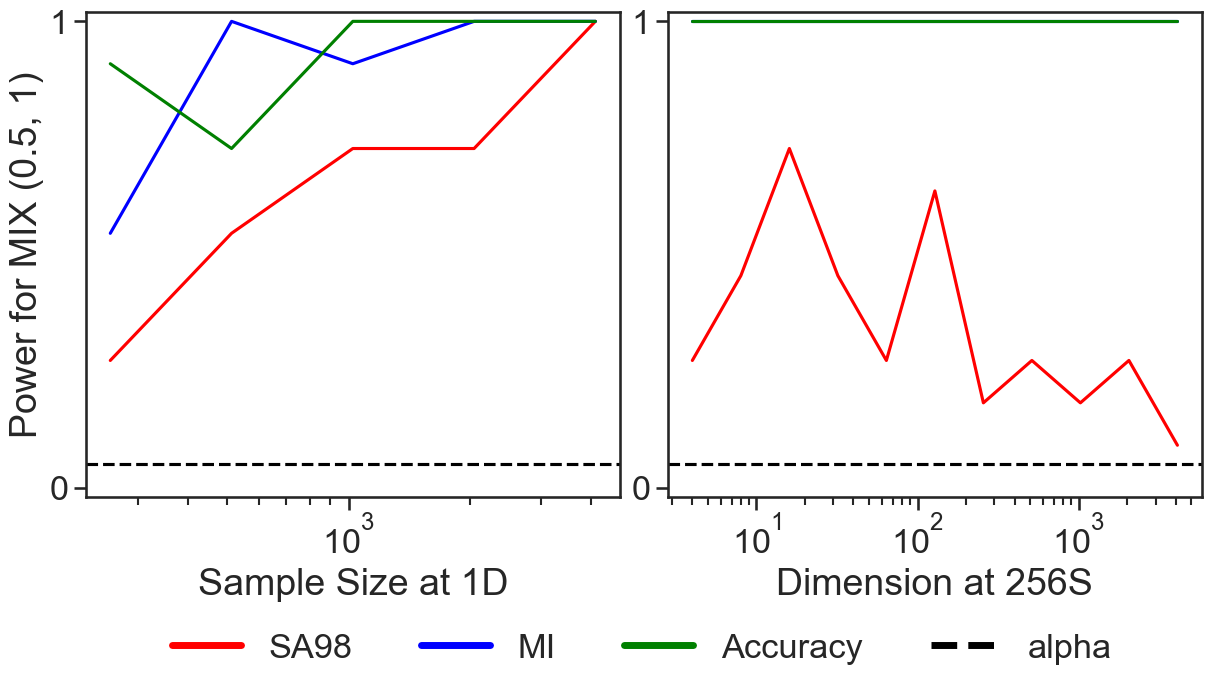

In [25]:
sns.set_theme(
    color_codes=True, palette="bright", style="ticks", context="talk", font_scale=1.5
)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
for i, col in enumerate(ax):
    col.set_xscale("log")
    col.set(ylim=(-0.02, 1.02), yticks=[0, 1])
    if i == 0:
        col.set_xlabel("Sample Size at 1D")
        col.set_ylabel("Power for MIX (0.5, 1)")
        col.plot(SAMPLE_SIZES, SA98_POWERS, color="red", label="SA98")
        col.plot(SAMPLE_SIZES, MI_POWERS, color="blue", label="MI")
        col.plot(SAMPLE_SIZES, ACC_POWERS, color="green", label="Accuracy")
        col.axhline([0.05], color="black", ls="--", label="alpha")
    elif i == 1:
        col.set_xlabel("Dimension at 256S")
        col.plot(DIM_SIZES, SA98_POWERS_DIM, color="red")
        col.plot(DIM_SIZES, MI_POWERS_DIM, color="blue")
        col.plot(DIM_SIZES, ACC_POWERS_DIM, color="green")
        col.axhline([0.05], color="black", ls="--")


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.15),
    bbox_transform=plt.gcf().transFigure,
    ncol=6,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
    legobj.set_linewidth(5.0)